In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf 
import keras
from keras import layers
from tensorflow.keras.models import load_model , Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPooling2D , Conv2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pydicom

In [11]:
path = "/home/lucas/Documents/diretorio/redes/raiox/manifest-1617826555824/Pseudo-PHI-DICOM-Data/339833062/07-05-2001-NA-NA-19638/3001578.000000-NA-60758/1-1.dcm"

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 186
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.463628102274132074849128424375172598
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', '']
(0008,0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008,0018) SOP Instance UID                    UI: 2.25.46362810227413

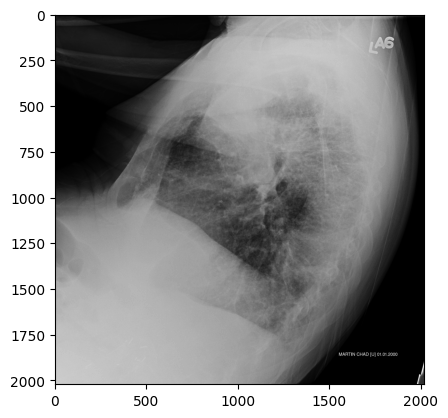

In [12]:
# Ler o arquivo DICOM
dicom_data = pydicom.dcmread(path)

# Exibir os dados do arquivo
print(dicom_data)

# Acessar os dados da imagem
pixel_array = dicom_data.pixel_array

# Exibir a imagem
plt.imshow(pixel_array, cmap="gray")
plt.show()

In [26]:
import os
import pydicom
import pandas as pd

# Função para extrair os metadados de um arquivo DICOM
def extract_metadata(dicom_file):
    # Lista de metadados que você deseja extrair
    metadata = {
        'PatientID': dicom_file.PatientID if 'PatientID' in dicom_file else 'unknown',
        'PatientName': dicom_file.PatientName if 'PatientName' in dicom_file else 'unknown',
        'StudyDate': dicom_file.StudyDate if 'StudyDate' in dicom_file else 'unknown'
    }
    return metadata

# Função para percorrer a pasta e extrair os metadados de todos os arquivos DICOM
def process_dicom_folder(folder_path):
    metadata_list = []
    
    # Percorrer todos os arquivos na pasta
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dcm"):
                filepath = os.path.join(root, file)
                dicom_file = pydicom.dcmread(filepath)
                
                # Extrair os metadados
                metadata = extract_metadata(dicom_file)
                metadata_list.append(metadata)
    
    return metadata_list

# Caminho para a pasta contendo os arquivos DICOM
folder_path = 'manifest-1617826555824/Pseudo-PHI-DICOM-Data/339833062/07-05-2001-NA-NA-19638/3001578.000000-NA-60758'

# Processar a pasta e obter os metadados
dicom_metadata = process_dicom_folder(folder_path)

# Criar um DataFrame pandas com os metadados
df = pd.DataFrame(dicom_metadata)

# Salvar o DataFrame em um arquivo CSV
output_csv_path = 'dicom_metadata.csv'
df.to_csv(output_csv_path, index=False)

print(f'Metadados salvos em {output_csv_path}')


Metadados salvos em dicom_metadata.csv


In [8]:
img_size = 256
train = image_dataset_from_directory(
                                    path,
                                    image_size = (img_size,img_size),
                                    shuffle = True,
                                    label_mode = "categorical",
                                    subset = "training",
                                    validation_split = 0.3,
                                    seed=47)
test = image_dataset_from_directory(
                                    path,
                                    image_size = (img_size,img_size),
                                    shuffle = True,
                                    label_mode = "categorical",
                                    subset = "validation",
                                    validation_split = 0.2,
                                    seed=47)
val = image_dataset_from_directory(
                                    path,
                                    image_size = (img_size,img_size),
                                    shuffle = True,
                                    label_mode = "categorical",
                                    subset = "validation",
                                    validation_split = 0.1,
                                    seed=47)

NotFoundError: Could not find directory 1.dcm

In [4]:
class_names = train.class_names
class_names

['aneurysm', 'cancer', 'tumor']

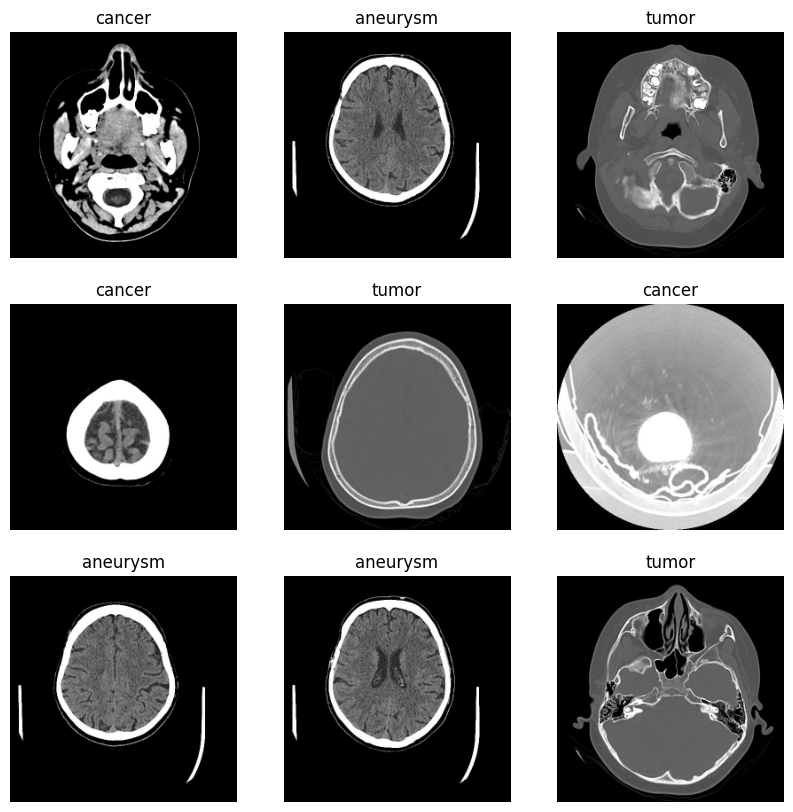

In [5]:
plt.figure(figsize=(10,10))
for image , label in test.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label.numpy()[i])])
        plt.axis("off")
plt.show()

In [6]:
model = Sequential([
    tf.keras.layers.Rescaling(1/255),
    Conv2D(64,(3,3),activation='relu', input_shape=(img_size,img_size,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2))
])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.add(layers.Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [9]:
hist = model.fit(train , validation_data=val,epochs=20)

Epoch 1/20
2/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4219 - loss: 1.0952 

I0000 00:00:1723124151.227946      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723124151.247606      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.5622 - loss: 0.9041 - val_accuracy: 0.9600 - val_loss: 0.3527
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9405 - loss: 0.2829 - val_accuracy: 0.9600 - val_loss: 0.1556
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9785 - loss: 0.1027 - val_accuracy: 1.0000 - val_loss: 0.0504
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9831 - loss: 0.0544 - val_accuracy: 0.9600 - val_loss: 0.0730
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9960 - loss: 0.0203 - val_accuracy: 0.9600 - val_loss: 0.0960
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9759 - loss: 0.0353 - val_accuracy: 0.9200 - val_loss: 0.1230
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9940 - loss: 0.0197 - val_accuracy: 0.9600 - val_loss: 0.0614
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9940 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0438
Epoch 9/20
6

In [10]:
model.evaluate(test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9375 - loss: 0.1491

W0000 00:00:1723124175.434856      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.9400 - loss: 0.1360


[0.12938417494297028, 0.9411764740943909]

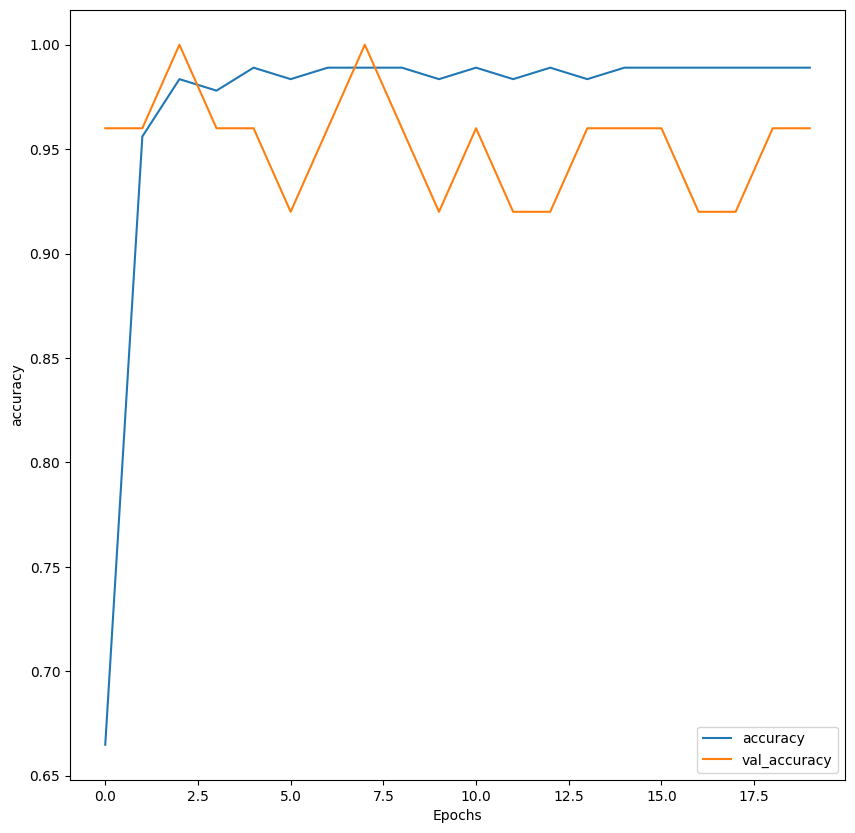

In [11]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

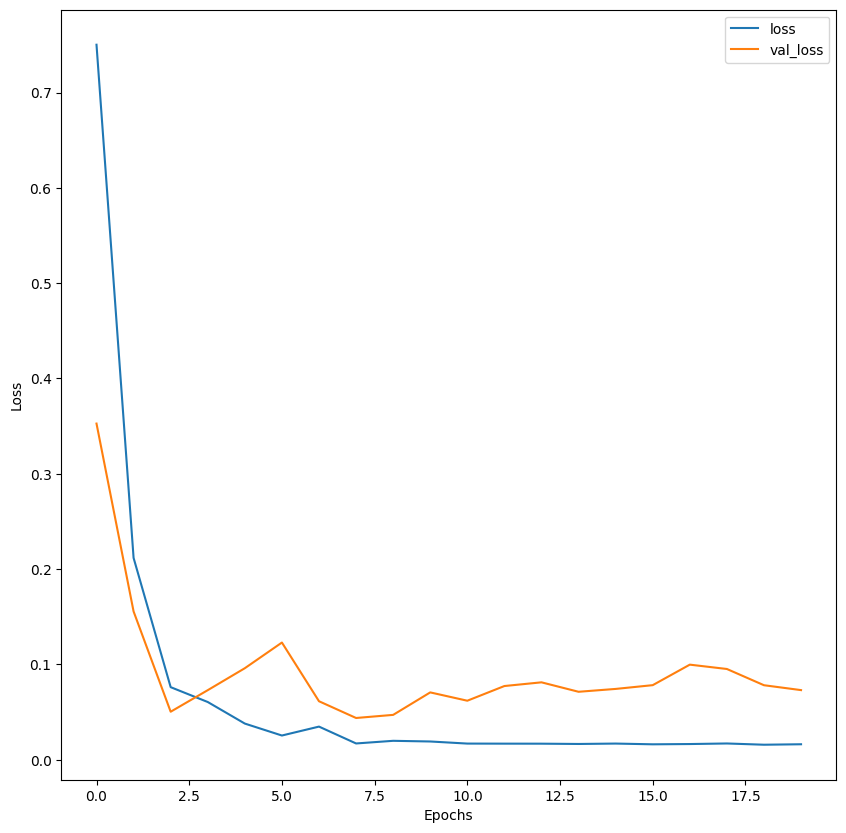

In [12]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'],label='loss')
plt.plot(hist.history['val_loss'],label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [13]:
model.save('model.h5')

In [14]:
model = load_model('model.h5')

classes = {
    0: 'aneurysm',
    1: 'cancer',
    2: 'tumor'
}

class_names = list(classes.values())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


W0000 00:00:1723124180.404539      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


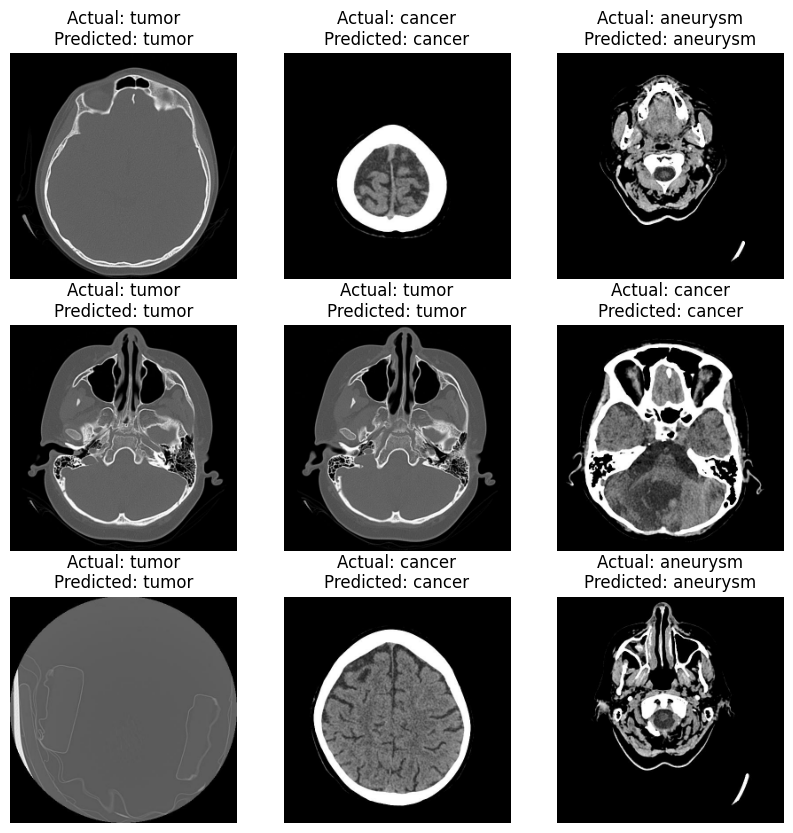

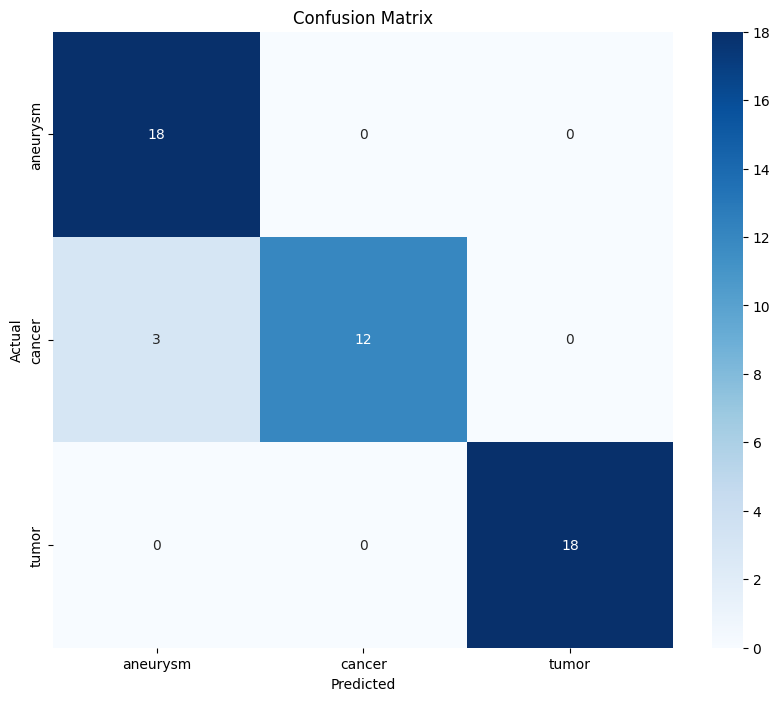

In [15]:
def display_predictions(model, test_data, class_names):
    actual_labels = []
    predicted_labels = []

    for img, label in test_data:
        pred = model.predict(img)
        actual_labels.extend([np.argmax(l) for l in label.numpy()])
        predicted_labels.extend([np.argmax(p) for p in pred])

    # Plot images with actual and predicted labels
    for img, label in test_data.take(1):
        plt.figure(figsize=(10, 10))
        pred = model.predict(img)
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            actual_label = class_names[np.argmax(label.numpy()[i])]
            predicted_label = class_names[np.argmax(pred[i])]
            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
            plt.imshow(img[i].numpy().astype("uint8"))
            plt.axis("off")
        plt.show()
        return actual_labels, predicted_labels
    
actual_labels, predicted_labels = display_predictions(model, test, class_names)

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()